# Building your own algorithm container


### The parts of the sample container

In the `container` directory are all the components you need to package the sample algorithm for Amazon SageMager:

    
    |-- Dockerfile
    `-- decision_trees
        |-- nginx.conf
        |-- predictor.py
        |-- serve
        |-- train
        `-- wsgi.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We'll invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`decision_trees`__ is the directory which contains the files that will be installed in the container.
* __`local_test`__ is a directory that shows how to test your new container on any computer that can run Docker, including an Amazon SageMaker notebook instance. Using this method, you can quickly iterate using small datasets to eliminate any structural bugs before you use the container with Amazon SageMaker. We'll walk through local testing later in this notebook.

In this simple application, we only install five files in the container. You may only need that many or, if you have many supporting routines, you may wish to install more. These five show the standard structure of our Python containers, although you are free to choose a different toolset and therefore could have a different layout. If you're writing in a different programming language, you'll certainly have a different layout depending on the frameworks and tools you choose.

The files that we'll put in the container are:

* __`nginx.conf`__ is the configuration file for the nginx front-end. Generally, you should be able to take this file as-is.
* __`predictor.py`__ is the program that actually implements the Flask web server and the decision tree predictions for this app. You'll want to customize the actual prediction parts to your application. Since this algorithm is simple, we do all the processing here in this file, but you may choose to have separate files for implementing your custom logic.
* __`serve`__ is the program started when the container is started for hosting. It simply launches the gunicorn server which runs multiple instances of the Flask app defined in `predictor.py`. You should be able to take this file as-is.
* __`train`__ is the program that is invoked when the container is run for training. You will modify this program to implement your training algorithm.
* __`wsgi.py`__ is a small wrapper used to invoke the Flask app. You should be able to take this file as-is.

In summary, the two files you will probably want to change for your application are `train` and `predictor.py`.

## Let's follow step by step

### 1. Let's create "train.py" of our algorithm for container, it should be without extension in folder. 

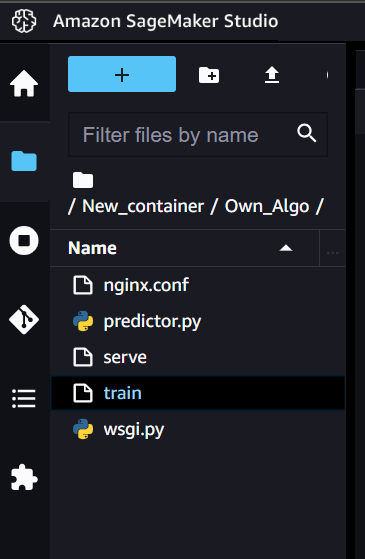

***Remember that, train.py and serve.py should be without extension in folder.***

### 2. The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we will start from a standard Ubuntu installation and run the normal tools to install the things needed by scikit-learn. Finally, we add the code that implements our specific algorithm to the container and set up the right environment to run under.

Along the way, we clean up extra space. This makes the container smaller and faster to start.

Let's look at the Dockerfile for the example:

In [2]:
!cat Algo_Container/Dockerfile

# Build an image that can do training and inference in SageMaker
# This is a Python 3 image that uses the nginx, gunicorn, flask stack
# for serving inferences in a stable way.

FROM ubuntu:18.04

MAINTAINER Amazon AI <sage-learner@amazon.com>


RUN apt-get -y update && apt-get install -y --no-install-recommends \
         wget \
         python3-pip \
         python3-setuptools \
         nginx \
         ca-certificates \
    && rm -rf /var/lib/apt/lists/*

RUN ln -s /usr/bin/python3 /usr/bin/python
RUN ln -s /usr/bin/pip3 /usr/bin/pip

# Here we get all python packages.
# There's substantial overlap between scipy and numpy that we eliminate by
# linking them together. Likewise, pip leaves the install caches populated which uses
# a significant amount of space. These optimizations save a fair amount of space in the
# image, which reduces start up time.
RUN pip --no-cache-dir install numpy==1.16.2 scipy==1.2.1 scikit-learn==0.20.2 pandas flask gunicorn

# Set some environment variabl

### 3. Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh decision_trees_sample` to build the image `decision_trees_sample`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this will be the region where the notebook instance was created). If the repository doesn't exist, the script will create it.

***`sagemaker-studio-image-build` is needed to have the run Docker in Sagemaker Studio***

In [3]:
!pip install sagemaker-studio-image-build 

  Using cached sagemaker_studio_image_build-0.6.0-py3-none-any.whl
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.16-py2.py3-none-any.whl.metadata (48 kB)
Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.3.3 which is incompatible.


In [ ]:
## Trust Policy for IAM Role

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "codebuild.amazonaws.com"
            },
            "Action": "sts:AssumeRole"
        }
    ]
}

In [4]:
%%sh

# The name of our algorithm
algorithm_name=custom-algorithm-sklearn

cd Algo_Container

chmod +x Decision_Tree/train
chmod +x Decision_Tree/serve

fullname="${algorithm_name}:latest"
sm-docker build . --role Sagemaker_build_role --repository ${fullname} \
 --bucket sagemaker-tutorials-mlhub

................[Container] 2023/09/16 06:25:58 Waiting for agent ping

[Container] 2023/09/16 06:25:59 Waiting for DOWNLOAD_SOURCE
[Container] 2023/09/16 06:26:03 Phase is DOWNLOAD_SOURCE
[Container] 2023/09/16 06:26:03 CODEBUILD_SRC_DIR=/codebuild/output/src2195072834/src
[Container] 2023/09/16 06:26:03 YAML location is /codebuild/output/src2195072834/src/buildspec.yml
[Container] 2023/09/16 06:26:03 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2023/09/16 06:26:03 Processing environment variables
[Container] 2023/09/16 06:26:03 No runtime version selected in buildspec.
[Container] 2023/09/16 06:26:03 Moving to directory /codebuild/output/src2195072834/src
[Container] 2023/09/16 06:26:03 Configuring ssm agent with target id: codebuild:52cf4c75-febe-477c-9b28-60f99cf5d247
[Container] 2023/09/16 06:26:03 Successfully updated ssm agent configuration
[Container] 2023/09/16 06:26:03 Registering with agent
[Container] 2023/09/16 06:26:03 Phases found in YAML: 3
[C

***Copy this Image URI***

In [17]:
# 179822996285.dkr.ecr.ap-south-1.amazonaws.com/custom-algorithm-sklearn:latest

### 4. Testing of your algorithm in Sagemaker

Once you have your container packaged, you can use it to train models and use the model for hosting or batch transforms. Let's do that with the algorithm we made above.



Here we specify a bucket to use and the role that will be used for working with SageMaker.

In [5]:
# S3 prefix
prefix = "DEMO-scikit-byo-iris"

# Define IAM role
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### Create the session

The session remembers our connection parameters to SageMaker. We'll use it to perform all of our SageMaker operations.

In [6]:
import sagemaker as sage
from time import gmtime, strftime

sess = sage.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### Create an estimator and fit the model

In order to use SageMaker to fit our algorithm, we'll create an `Estimator` that defines how to use the container to train. This includes the configuration we need to invoke SageMaker training:

* The __container name__. This is constructed as in the shell commands above.
* The __role__. As defined above.
* The __instance count__ which is the number of machines to use for training.
* The __instance type__ which is the type of machine to use for training.
* The __output path__ determines where the model artifact will be written.
* The __session__ is the SageMaker session object that we defined above.

Then we use fit() on the estimator to train against the data that we uploaded above.

In [7]:
data_location = 's3://sagemaker-tutorials-mlhub/Algo_Container'
data_location 

's3://sagemaker-tutorials-mlhub/Algo_Container'

In [8]:
# ECR Image URI of our created algorithm

image = "179822996285.dkr.ecr.ap-south-1.amazonaws.com/custom-algorithm-sklearn:latest"
image

'179822996285.dkr.ecr.ap-south-1.amazonaws.com/custom-algorithm-sklearn:latest'

### 5. Setting up Algorithm Estimator

In [9]:
param_dict = {
 "max_leaf_nodes":3,
 "random_state": 0,
 "criterion":"gini"
}

In [10]:
estimator = sage.estimator.Estimator(
    image,
    role,
    1,
    "ml.c4.2xlarge",
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    hyperparameters=param_dict,
    train_use_spot_instances=True,  # Specify the use of spot instances
    train_max_run=3600,  # Maximum time for training job in seconds (optional)
    train_max_wait=7200 
)

train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
estimator.fit(data_location, logs=True)

INFO:sagemaker:Creating training-job with name: custom-algorithm-sklearn-2023-09-16-06-32-24-237


2023-09-16 06:32:24 Starting - Starting the training job...
2023-09-16 06:32:49 Starting - Preparing the instances for training.........
2023-09-16 06:34:23 Downloading - Downloading input data...
2023-09-16 06:34:54 Training - Training image download completed. Training in progress.
2023-09-16 06:34:54 Uploading - Uploading generated training model.[INFO] Starting the training.....
[INFO] Hyperparameters:  {'criterion': 'gini', 'max_leaf_nodes': '3', 'random_state': '0'}
[INFO] Found following training files:  ['/opt/ml/input/data/training/iris.csv']
[INFO] Training complete.
[INFO] Model saved at: /opt/ml/model.

2023-09-16 06:35:05 Completed - Training job completed
Training seconds: 42
Billable seconds: 16
Managed Spot Training savings: 61.9%


### 5. Deploy the model as Endpoint

In [12]:
from sagemaker.serializers import CSVSerializer

predictor = estimator.deploy(1, "ml.m4.xlarge", serializer=CSVSerializer())

INFO:sagemaker:Creating model with name: custom-algorithm-sklearn-2023-09-16-06-36-20-028
INFO:sagemaker:Creating endpoint-config with name custom-algorithm-sklearn-2023-09-16-06-36-20-028
INFO:sagemaker:Creating endpoint with name custom-algorithm-sklearn-2023-09-16-06-36-20-028


---!

### 6. Test the endpoint

In [13]:
shape = pd.read_csv("iris.csv", header=None)
shape.sample(3)

,0,1,2,3,4
96,versicolor,5.7,2.9,4.2,1.3
61,versicolor,5.9,3.0,4.2,1.5
15,setosa,5.7,4.4,1.5,0.4


In [14]:
# drop the label column in the training set
shape.drop(shape.columns[[0]], axis=1, inplace=True)
shape.sample(3)

,1,2,3,4
65,6.7,3.1,4.4,1.4
122,7.7,2.8,6.7,2.0
86,6.7,3.1,4.7,1.5


In [15]:
import itertools

a = [50 * i for i in range(3)]
b = [40 + i for i in range(10)]
indices = [i + j for i, j in itertools.product(a, b)]

test_data = shape.iloc[indices[:-1]]

In [16]:
print(predictor.predict(test_data.values).decode("utf-8"))

setosa
setosa
setosa
setosa
setosa
setosa
setosa
setosa
setosa
setosa
versicolor
versicolor
versicolor
versicolor
versicolor
versicolor
versicolor
versicolor
versicolor
versicolor
virginica
virginica
virginica
virginica
virginica
virginica
virginica
virginica
virginica



### 6. Clean-up

In [33]:
sess.delete_endpoint(predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: custom-algorithm-sklearn-2023-09-15-11-08-18-933
